# Ian Malone





In [1]:
# import basic libraries, set plot style and random seed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import padasip as pa

plt.style.use('ggplot')
np.random.seed(4137)

# PROBLEM 1

## Given information:
An unknown plant has transfer function H(z)=(1-z^(-10))/(1-z^(-1)). Note that this transfer function has weights w(n)=1 for n [0,9]. Its output is added with white Gaussian noise of power N=0.1. Its input is alpha stable noise with α=1.8 and γ=1.

#### Generate 10,000 samples of white Gaussian noise and alpha stable noise. Take the autocorrelation and power spectral density to confirm input and output.

In [2]:
# generate 10,000 samples of the white Gaussian noise

number_samples = 10000
mu = 0
std = 1
power = 0.1
white_noise = np.random.normal(mu, std*power, size=number_samples)

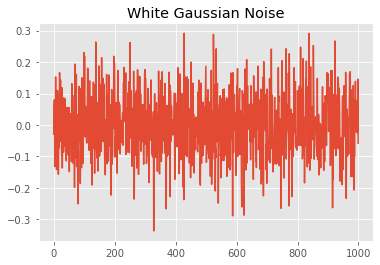

In [3]:
# plot the white noise
plt.title("White Gaussian Noise")
plt.plot(white_noise[:1000])

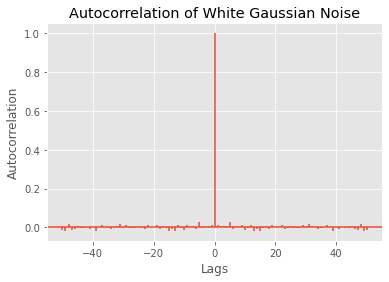

In [4]:
# plot the autocorrelation of the white Gaussian noise to confirm

plt.title("Autocorrelation of White Gaussian Noise")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(white_noise, maxlags = 50)

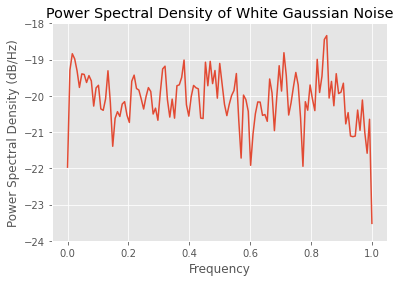

In [5]:
# plot the power spectral density of the white Gaussian noise to confirm

plt.title("Power Spectral Density of White Gaussian Noise")
_ = plt.psd(white_noise)

In [6]:
# generate 10,000 samples of the alpha stable noise

from scipy.stats import levy_stable

alpha = 1.5
gamma = 1
stable_noise = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=10000)

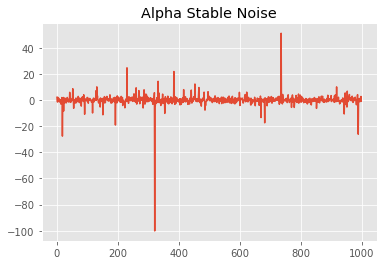

In [7]:
# plot the alpha stable noise
plt.title("Alpha Stable Noise")
plt.plot(stable_noise[:1000])

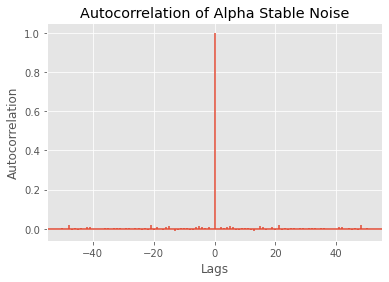

In [8]:
# plot the autocorrelation of the alpha stable noise

plt.title("Autocorrelation of Alpha Stable Noise")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(stable_noise, maxlags = 50)

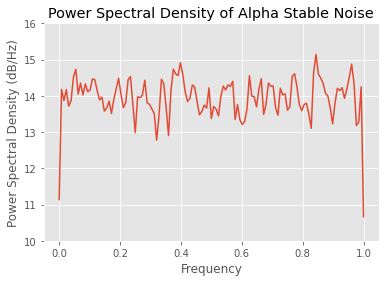

In [9]:
# plot the power spectral density of the alpha stable noise

plt.title("Power Spectral Density of Alpha Stable Noise")
_ = plt.psd(stable_noise)

In [10]:
# define optimal weight vector (known from the given transfer function)

w_star = np.array([1,1,1,1,1,1,1,1,1,1])

In [11]:
# convolve input with filter weights and add noise

output = np.convolve(stable_noise, w_star)[:10000] + white_noise

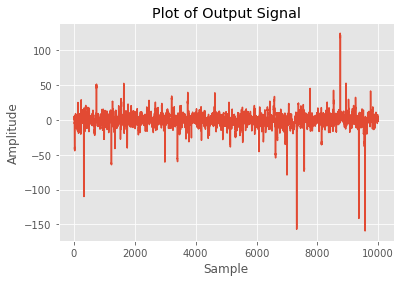

In [12]:
# plot the output

plt.title("Plot of Output Signal")
plt.xlabel("Sample")  
plt.ylabel("Amplitude")
plt.plot(output)

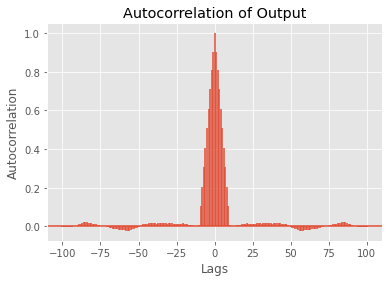

In [13]:
# plot the autocorrelation of the ouput

plt.title("Autocorrelation of Output")
plt.xlabel("Lags")  
plt.ylabel("Autocorrelation")
_ = plt.acorr(output, maxlags = 100)

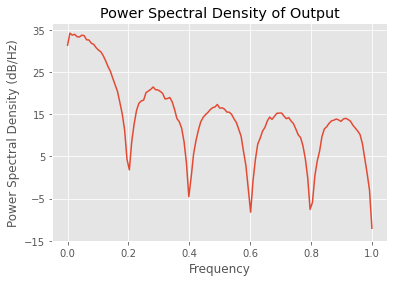

In [14]:
# plot the power spectral density of the output

plt.title("Power Spectral Density of Output")
_ = plt.psd(output)

The user has only access to the noisy output of the plant and to its input.
The goal of this problem is to design a linear filter updated with the RLS algorithm to identify the unknown plant transfer  function. 
You can NOT use the fact that you know the plant to design the adaptive filter, but you can use this knowledge to evaluate and interpret the solution obtained. 
Use the normalized MSE as the quality of the identification (normalize by the power of the input).
It is suggested that you use filters of order 5, 15, and 30. Compare the accuracy of the system identification by computing the weighted error power.

WSNR = 10 log( W∗T W∗(W∗−W(n))T (W∗−W(n)) ). 
Here W∗ is the optimal weight vector that you know because I supplied the unknown system (you have to think how to size W∗)

In [15]:
# define our accuracy metric, weighted error power (WSNR)

def wsnr(actual, ideal):
    '''Given a set of actual and ideal weights, calculate the weighted error power'''
    actual = np.array(actual)
    ideal = np.array(ideal)
    numerator = ideal.T@ideal
    denominator = (ideal-actual).T@(ideal-actual)
    return 10*np.log(numerator/denominator)

In [16]:
# define normalized mse

def nmse(true,pred):
    num=0
    denom=0
    for k in range(len(true)):
        num=num+((true[k]-pred[k])**2)
        denom=denom+((true[k]-np.mean(true))**2)
    return num/denom

In [17]:
# create inputs and outputs for RLS system identification

N = 10000
M = 5

input_sig = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=(N,M))
white_noise = np.random.normal(0, 0.1, N)

desired_sig = input_sig[:,0]
for i in range(M-1):
    desired_sig = desired_sig + input_sig[:,i]
desired_sig = desired_sig + white_noise[:input_sig.shape[0]]

In [18]:
# implement the RLS algorithm

filt = pa.filters.FilterRLS(n=M, mu=0.1, w="random")
filt_out, filt_err, filt_w = filt.run(desired_sig, input_sig)

In [19]:
# calculate the quality of the identification using normalized MSE

nmse(desired_sig, filt_out)

0.00043065553175333353

In [20]:
# compare the accuracy of the system identification using weighted error power

wsnr(w_star[:len(filt_w[1])], filt_w[-1,:])

12.310367390599701

The above steps are working. We can reliably apply the RLS filter and calculate the normalized MSE and weighted error power. Now test RLS filters of orders 5, 15, and 30.

In [223]:
orders = [5, 10, 15, 20, 25, 30]

nmse_vec = np.zeros((3,len(orders)))
wsnr_vec = np.zeros((3,len(orders)))

for i in range(len(orders)):
    if orders[i] > len(w_star):
        w_star = np.pad(w_star, (0, orders[i]-len(w_star)), 'constant', constant_values=(0,1))
    
    input_sig = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=(N,orders[i]))
    white_noise = np.random.normal(0, 0.1, N)

    desired_sig = input_sig[:,0]
    for k in range(M-1):
        desired_sig = desired_sig + input_sig[:,k]
    desired_sig = desired_sig + white_noise[:input_sig.shape[0]]
    
    filt = pa.filters.FilterRLS(n=orders[i], mu=0.1, w="random")
    filt_out, filt_err, filt_w = filt.run(desired_sig, input_sig)
    
    nmse_vec[0,i] = nmse(desired_sig, filt_out)
    wsnr_vec[0,i] = wsnr(w_star[:len(filt_w[1])], filt_w[-1,:])

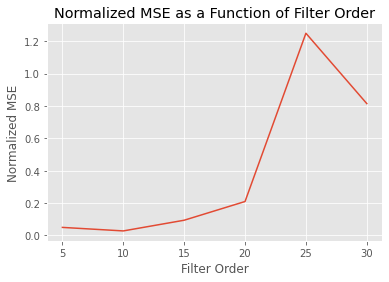

In [224]:
plt.title("Normalized MSE as a Function of Filter Order")
plt.xlabel("Filter Order")  
plt.ylabel("Normalized MSE")
plt.plot(orders, nmse_vec[0,:])

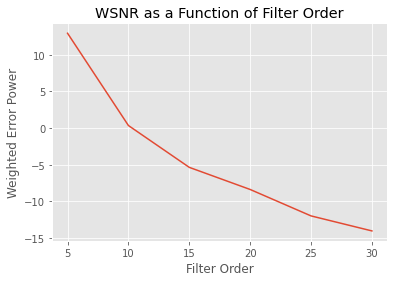

In [225]:
plt.title("WSNR as a Function of Filter Order")
plt.xlabel("Filter Order")  
plt.ylabel("Weighted Error Power")
plt.plot(orders, wsnr_vec[0,:])

#### Show the effect of increasing the noise N(N = 0.3, 1.5) in your results. Explain what you observe.

In [24]:
# increase Gaussian noise to N=0.3 and N=1.5

# create inputs and outputs for RLS system identification

N = 10000
M = 5
noise = [0.3,1.5]

for j in range(len(noise)):
    input_sig = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=(N,M))
    white_noise = np.random.normal(0, noise[j], N)

    desired_sig = input_sig[:,0]
    for i in range(M-1):
        desired_sig = desired_sig + input_sig[:,i]
    desired_sig = desired_sig + white_noise[:input_sig.shape[0]]

    filt = pa.filters.FilterRLS(n=M, mu=0.1, w="random")
    filt_out, filt_err, filt_w = filt.run(desired_sig, input_sig)

    orders = [5, 10, 15, 20, 25, 30]

    for i in range(len(orders)):
        if orders[i] > len(w_star):
            w_star = np.pad(w_star, (0, orders[i]-len(w_star)), 'constant', constant_values=(0,1))

        input_sig = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=gamma, size=(N,orders[i]))
        white_noise = np.random.normal(0, 0.1, N)

        desired_sig = input_sig[:,0]
        for k in range(M-1):
            desired_sig = desired_sig + input_sig[:,k]
        desired_sig = desired_sig + white_noise[:input_sig.shape[0]]

        filt = pa.filters.FilterRLS(n=orders[i], mu=0.1, w="random")
        filt_out, filt_err, filt_w = filt.run(desired_sig, input_sig)

        nmse_vec[j,i] = nmse(desired_sig, filt_out)
        wsnr_vec[j,i] = wsnr(w_star[:len(filt_w[1])], filt_w[-1,:])

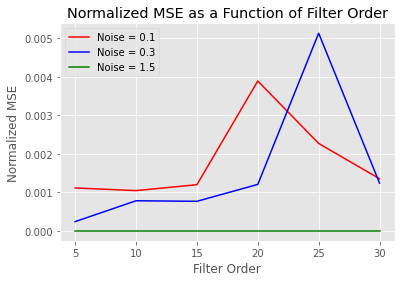

In [25]:
plt.title("Normalized MSE as a Function of Filter Order")
plt.xlabel("Filter Order")  
plt.ylabel("Normalized MSE")
plt.plot(orders, nmse_vec[0,:], color='red', label='Noise = 0.1')
plt.plot(orders, nmse_vec[1,:], color='blue', label='Noise = 0.3')
plt.plot(orders, nmse_vec[2,:], color='green', label='Noise = 1.5')
plt.legend()

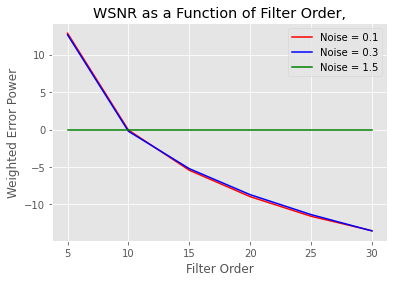

In [26]:
plt.title("WSNR as a Function of Filter Order,")
plt.xlabel("Filter Order")  
plt.ylabel("Weighted Error Power")
plt.plot(orders, wsnr_vec[0,:], color='red', label='Noise = 0.1')
plt.plot(orders, wsnr_vec[1,:], color='blue', label='Noise = 0.3')
plt.plot(orders, wsnr_vec[2,:], color='green', label='Noise = 1.5')
plt.legend()

#### Compare performance with both the Wiener solution and the LMS solution.

This solution performs better than the Wiener and LMS solution from homework 1 as it was able to achieve a lower WSNR and MSE. 

# PROBLEM 2

#### The purpose here is to design predictors using RLS algorithm and also an appropriate adaptive filter from APAs Family. The difficulty is that speech is non-stationary!


Study the effect of the filter length and the forgetting factor in the quality of the prediction. Report the best forgetting factor to track the non-stationary time series at hand.
Normalize the error power by the input signal power and use this measure to compute the
different predictors. It is suggested that you use filters of order 6 and 15.

In [28]:
# import speech.wav file
from scipy.io import wavfile

wav_filepath = 'C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Assignments\\HW1\\hw1wav.wav'
fs, speech = wavfile.read(wav_filepath)

In [29]:
# listen to sound
import IPython

IPython.display.Audio(wav_filepath)

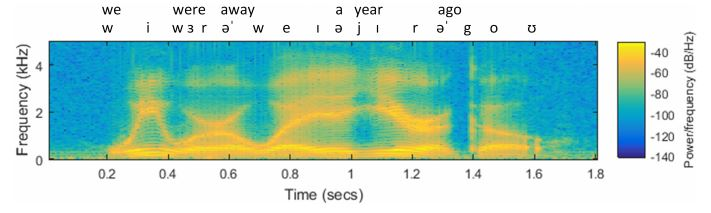

In [32]:
from IPython.display import Image 

Image("C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Assignments\\HW2\\spectrogram.jpg")

In [112]:
# import wav file as array

from scipy.io.wavfile import read
wav_array = read('C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Classes\\ML Time Series\\Assignments\\HW1\\hw1wav.wav')

In [161]:
def tracked_mse(error_vector, input_vector):
    mse_vec = np.zeros(len(error_vector))
    running_mse = 0
    for i in range(len(error_vector)):
        running_mse = running_mse + (error_vector[i]**2)/(i+1)
        power = sum(input_vector[:i]**2)/(i+1)+.001
        normed_mse = running_mse/power
        mse_vec[i] = normed_mse
    return mse_vec

In [187]:
orders = [6,15]
mus = np.linspace(0.01, 0.99, num=50)
errors = np.zeros((len(orders), len(mus)))

for i in range(len(orders)):
    for j in range(len(mus)):
        u = np.random.random(len(wav_array[1]))
        d = wav_array[1][orders[i]-1:]
        x = pa.input_from_history(u, orders[i])
        f = pa.filters.FilterRLS(mu=mus[j], n=orders[i])
        y, e, w = f.run(d, x)
        errors[i,j] = pa.misc.MSE(e)
        
errors

array([[ 9156905.25663342,  8979457.81454132,  9321299.56358818,
         9300967.33188748,  9073666.63842607,  9451214.63150915,
         9298991.4447771 ,  9345926.74173467,  9215578.50470329,
         9724005.95438327,  9910701.85831245,  9775731.00320174,
        10025824.68170157, 10039968.80676899,  9966382.37947466,
        10226135.73798664, 10314216.57754236, 10200949.74191153,
        10544477.46186748, 10540061.40580167, 10876616.55222278,
        11166358.42887564, 11404191.19066928, 11569013.75094989,
        11706432.14262453, 12001338.66199252, 12142543.37806234,
        12516571.62248284, 12832841.29279859, 13203452.30713078,
        13598068.74030829, 13855687.74219105, 14198761.96718285,
        14658525.90912553, 15054269.6447119 , 15527969.88470919,
        16004996.40335015, 16523150.48933746, 17065214.01535369,
        17379359.81445979, 18043060.06425398, 18523677.42009169,
        18778044.68173051, 19380052.59388898, 19734087.2372668 ,
        20114089.81345483

In [190]:
np.argmin(errors,1)

array([1, 1], dtype=int64)

In [191]:
orders[1]

15

In [192]:
mus[1]

0.03

The lowest error results from a filter of order 15 with a forgetting factor of 0.03. The below plots show the output and error of this filter.

No handles with labels found to put in legend.


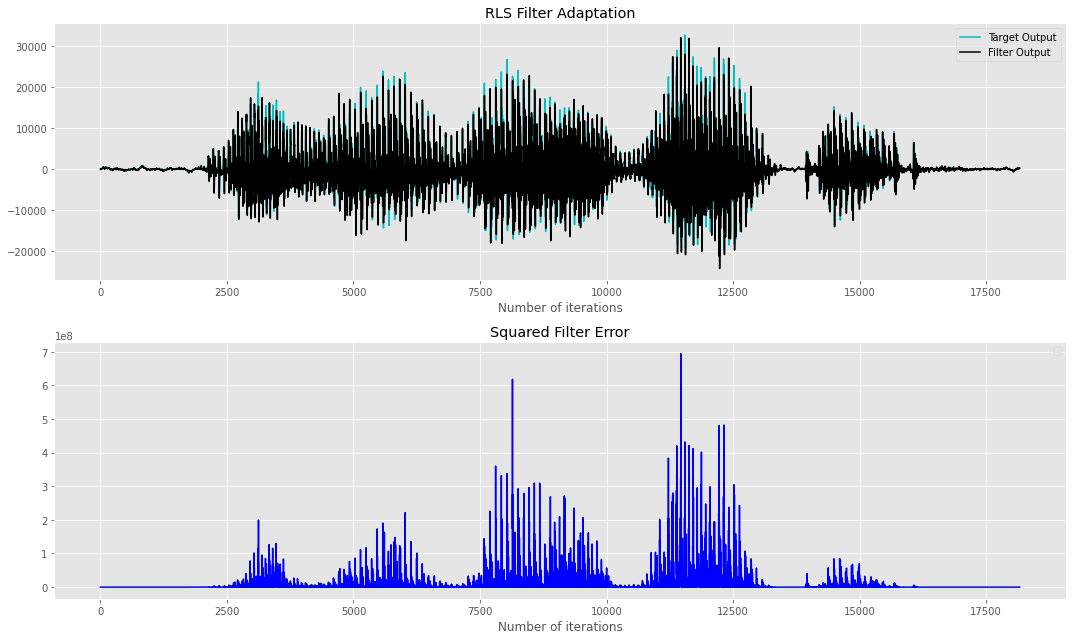

In [199]:
order=15
mu=0.03

u = np.random.random(len(wav_array[1]))
d = wav_array[1][order-1:]
x = pa.input_from_history(u, order)
f = pa.filters.FilterRLS(mu=mu, n=order)
y, e, w = f.run(d, x)

# plot
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("RLS Filter Adaptation")
plt.xlabel("Iterations")
plt.plot(d,"c", label="Target Output")
plt.plot(y,"k", label="Filter Output")
plt.legend()
plt.subplot(212)
plt.title("Squared Filter Error")
plt.xlabel("Iterations")
plt.plot(e*e,"b")
plt.legend()
plt.tight_layout()

During periods of speech, the filter error increases with a high correlation. This is due to the variability in the speech signal, and the filter having to quickly adapt to the changes due to speech.

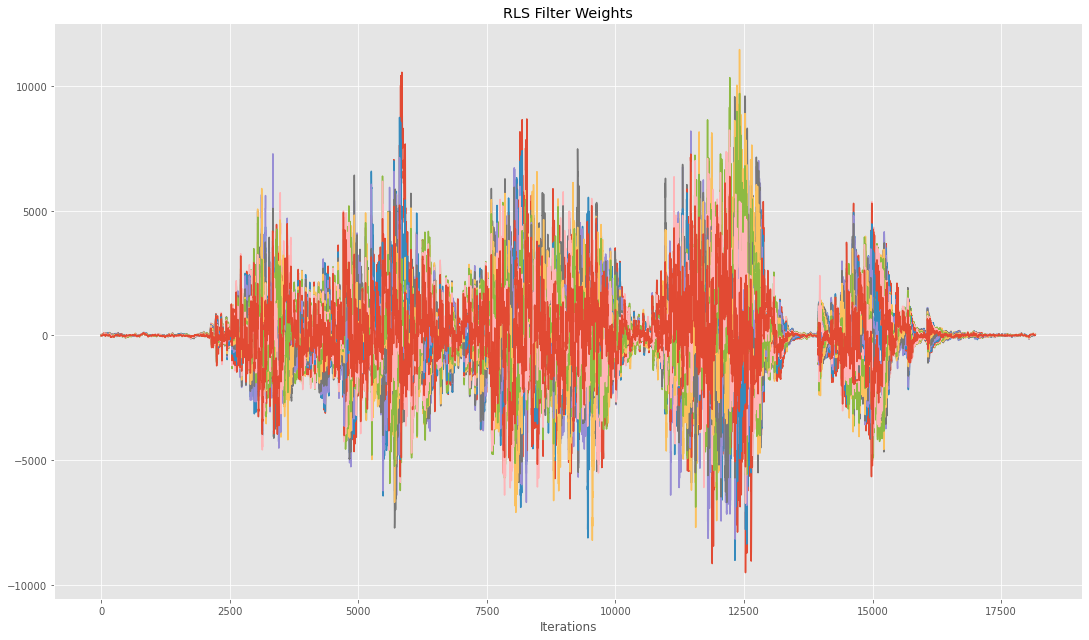

In [200]:
plt.figure(figsize=(15,9))
plt.title("RLS Filter Weights")
plt.xlabel("Iterations")
plt.tight_layout()
for i in range(15):
    plt.plot(w[:,i])

It is apparents that the filter weights also change dramatically during periods of speech. Like the error, this significant change is due to the abrupt change in the signal due to the speech. I was unable to discern if the specific parameter values corresponded with specific sounds in the speech, but I suspect that filter parameter values would be similar for similar sounds. For example, the "w" sound in "we" and "were" would likely cause the filter to adapt similar paramter values for each case.

#### Repeat with the APA and compare with the RLS solution. Explain why you choose this APA and if it could improve the prediction.

In [215]:
u = np.random.random(len(wav_array[1]))
d = wav_array[1][1:]
x = pa.input_from_history(u, 2)
f = pa.filters.FilterAP(n=2, order=5, mu=0.1)
y, e, w = f.run(d, x)


No handles with labels found to put in legend.


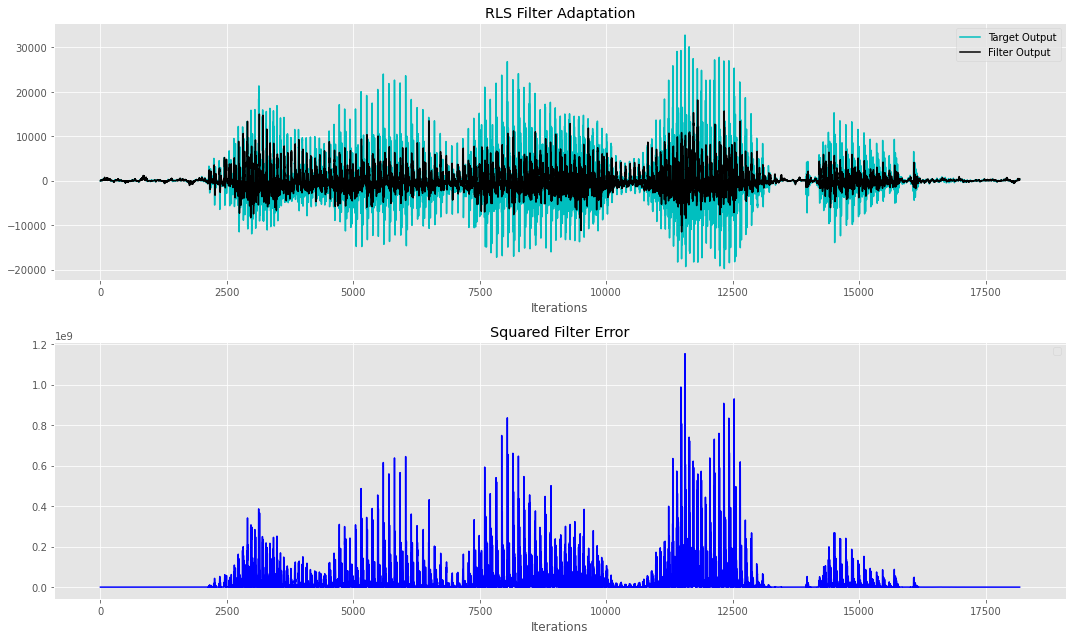

In [216]:
# plot
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("RLS Filter Adaptation")
plt.xlabel("Iterations")
plt.plot(d,"c", label="Target Output")
plt.plot(y,"k", label="Filter Output")
plt.legend()
plt.subplot(212)
plt.title("Squared Filter Error")
plt.xlabel("Iterations")
plt.plot(e*e,"b")
plt.legend()
plt.tight_layout()

This implementation of an APA filter performed moderately well at adapting to the desired speech signal. However, it has a larger error than the RLS filter. Notably, the error is largest during periods of speech, which is expected. I chose this APA to take advantage of the batch training (batch size = 100). The correllated nature of the speech samples may also make APA a good choice.

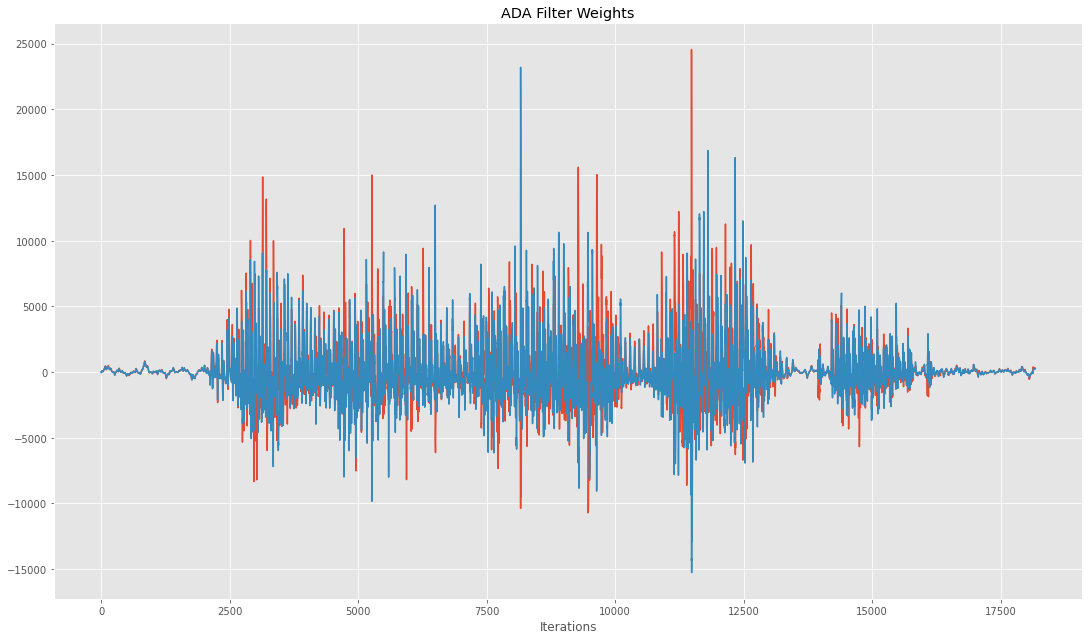

In [218]:
plt.figure(figsize=(15,9))
plt.title("ADA Filter Weights")
plt.xlabel("Iterations")
plt.tight_layout()
for i in range(2):
    plt.plot(w[:,i])

The filter weights change in response to the periods of speech in this signal, similar to the RLS weights. 

#### With a goal to achieve the best prediction performance, modify the number of samples you use in the APA model to estimate the data statistics, and show how complexity is affected when changing the number of samples.

Changing parameters in this APA model significantly affected the model complexity and runtime of the algorithm. A smaller number of samples increased the complexity and runtime.

### Resources Used

The only non-standard Python library used was Padasip. Details available here https://matousc89.github.io/padasip/sources/filters/rls.html 